![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.4.Biomedical_NER_SparkNLP_paper_reproduce.ipynb)

# Biomedical Named Entity Recognition (NER) at Scale

official paper : https://arxiv.org/abs/2011.06315

NER in Spark NLP Colab notebooks: https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/4.NERDL_Training.ipynb

## Blogposts and videos:



https://towardsdatascience.com/named-entity-recognition-ner-with-bert-in-spark-nlp-874df20d1d77

NerDL worksghop (90 min): https://www.youtube.com/watch?v=YM-e4eOiQ34

https://medium.com/spark-nlp/named-entity-recognition-for-healthcare-with-sparknlp-nerdl-and-nercrf-a7751b6ad571

https://medium.com/atlas-research/ner-for-clinical-text-7c73caddd180

## Colab Setup

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

In [ ]:
import sparknlp
import os

spark = sparknlp.start() # for GPU training >> sparknlp.start(gpu = True)

from sparknlp.base import *
from sparknlp.annotator import *

print("Spark NLP version", sparknlp.version())

print("Apache Spark version:", spark.version)

spark

Spark NLP version 3.3.0
Apache Spark version: 3.1.2


## CoNLL Data Prep 

We are going to use NCBI-Disease dataset in this notebook. All the other datasets used in the official paper arw prepared using the datasets at https://github.com/cambridgeltl/MTL-Bioinformatics-2016/tree/master/data. Since the data preparation steps from official tsv dfiles to conll format we utilize here is a time consuming and proprietary process, we share only one of them (**NCBI-Disease**) as an example. 

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/NCBI_disease_official_test.conll
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/NCBI_disease_official_train_dev.conll

In [ ]:
with open("NCBI_disease_official_test.conll") as f:
    train_txt =f.read()

print (train_txt[:500])

-DOCSTART- -X- -X- O

Clustering NN O O
of NN O O
missense NN O O
mutations NN O O
in NN O O
the NN O O
ataxia NN O B-Disease
- NN O I-Disease
telangiectasia NN O I-Disease
gene NN O O
in NN O O
a NN O O
sporadic NN O B-Disease
T NN O I-Disease
- NN O I-Disease
cell NN O I-Disease
leukaemia NN O I-Disease
. NN O O

Ataxia NN O B-Disease
- NN O I-Disease
telangiectasia NN O I-Disease
( NN O O
A NN O B-Disease
- NN O I-Disease
T NN O I-Disease
) NN O O
is NN O O
a NN O O
recessive NN O B-Disease
m


In [ ]:
from sparknlp.training import CoNLL

training_data = CoNLL().readDataset(spark, 'NCBI_disease_official_train_dev.conll')

training_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Identification of...|[{document, 0, 89...|[{document, 0, 89...|[{token, 0, 13, I...|[{pos, 0, 13, NN,...|[{named_entity, 0...|
|The adenomatous p...|[{document, 0, 21...|[{document, 0, 21...|[{token, 0, 2, Th...|[{pos, 0, 2, NN, ...|[{named_entity, 0...|
|Complex formation...|[{document, 0, 63...|[{document, 0, 63...|[{token, 0, 6, Co...|[{pos, 0, 6, NN, ...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [ ]:
training_data.count()

6347

In [ ]:
import pyspark.sql.functions as F

training_data.select(F.explode(F.arrays_zip('token.result', 'pos.result',  'label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("pos"),
        F.expr("cols['2']").alias("ner_label")).show(truncate=50)

+--------------+---+---------+
|         token|pos|ner_label|
+--------------+---+---------+
|Identification| NN|        O|
|            of| NN|        O|
|          APC2| NN|        O|
|             ,| NN|        O|
|             a| NN|        O|
|     homologue| NN|        O|
|            of| NN|        O|
|           the| NN|        O|
|   adenomatous| NN|B-Disease|
|     polyposis| NN|I-Disease|
|          coli| NN|I-Disease|
|        tumour| NN|I-Disease|
|    suppressor| NN|        O|
|             .| NN|        O|
|           The| NN|        O|
|   adenomatous| NN|B-Disease|
|     polyposis| NN|I-Disease|
|          coli| NN|I-Disease|
|             (| NN|I-Disease|
|           APC| NN|I-Disease|
+--------------+---+---------+
only showing top 20 rows



In [ ]:
training_data.select(F.explode(F.arrays_zip('token.result','label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth")).groupBy('ground_truth').count().orderBy('count', ascending=False).show(100,truncate=False)

+------------+------+
|ground_truth|count |
+------------+------+
|O           |146544|
|I-Disease   |7205  |
|B-Disease   |5921  |
+------------+------+



In [ ]:

test_data = CoNLL().readDataset(spark, 'NCBI_disease_official_test.conll')

test_data.select(F.explode(F.arrays_zip('token.result','label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth")).groupBy('ground_truth').count().orderBy('count', ascending=False).show(100,truncate=False)

+------------+-----+
|ground_truth|count|
+------------+-----+
|O           |22450|
|I-Disease   |1087 |
|B-Disease   |960  |
+------------+-----+



In [ ]:
# You can use any word embeddings you want (Glove, Elmo, Bert, custom etc.)

glove_embeddings = WordEmbeddingsModel.pretrained('glove_6B_300','xx')\
          .setInputCols(["sentence", "token"])\
          .setOutputCol("embeddings")
    

glove_6B_300 download started this may take some time.
Approximate size to download 426.2 MB
[OK!]


**We will get the embeddings for test set and write to disk as a parquet to be able to get metrics after each epoch during training.**

In [ ]:
glove_embeddings.transform(test_data).write.parquet('test_data_with_embeddings.parquet')

In [ ]:
!mkdir ner_logs

In [ ]:
nerTagger = NerDLApproach()\
      .setInputCols(["sentence", "token", "embeddings"])\
      .setLabelColumn("label")\
      .setOutputCol("ner")\
      .setMaxEpochs(10)\
      .setLr(0.003)\
      .setBatchSize(8)\
      .setRandomSeed(0)\
      .setVerbose(1)\
      .setEvaluationLogExtended(True) \
      .setEnableOutputLogs(True)\
      .setIncludeConfidence(True)\
      .setTestDataset('test_data_with_embeddings.parquet')\
      .setOutputLogsPath('ner_logs') # if not set, logs will be written to ~/annotator_logs
 #    .setGraphFolder('graphs') >> put your graph file (pb) under this folder if you are using a custom graph generated thru 4.1 NerDL-Graph.ipynb notebook
 #    .setEnableMemoryOptimizer() >> if you have a limited memory and a large conll file, you can set this True to train batch by batch 
    
# do hyperparameter by tuning the params above (max epoch, LR, dropout etc.) to get better results
ner_pipeline = Pipeline(stages=[
      glove_embeddings,
      nerTagger
 ])


### Fitting

In [ ]:
%%time

ner_model = ner_pipeline.fit(training_data)

# 1 epoch takes around 3 min with batch size=8
# if you get an error for incompatible TF graph, use 4.1 NerDL-Graph.ipynb notebook to create a graph

CPU times: user 8.1 s, sys: 813 ms, total: 8.92 s
Wall time: 32min 24s


In [ ]:
#! cd ~/annotator_logs && ls -lt
!cd ner_logs && ls -lt

total 8
-rw-r--r-- 1 root root 5016 Oct  9 10:22 NerDLApproach_c2dc051706e2.log


In [ ]:
!tail -n 10 ner_logs/NerDLApproach_af2879065348.log

tail: cannot open 'ner_logs/NerDLApproach_af2879065348.log' for reading: No such file or directory


### Test set evaluation

In [ ]:
import pyspark.sql.functions as F

predictions = ner_model.transform(test_data)

predictions.select(F.explode(F.arrays_zip('token.result','label.result','ner.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth"),
        F.expr("cols['2']").alias("prediction")).show(truncate=False)

+--------------+------------+----------+
|token         |ground_truth|prediction|
+--------------+------------+----------+
|Clustering    |O           |O         |
|of            |O           |O         |
|missense      |O           |O         |
|mutations     |O           |O         |
|in            |O           |O         |
|the           |O           |O         |
|ataxia        |B-Disease   |B-Disease |
|-             |I-Disease   |I-Disease |
|telangiectasia|I-Disease   |I-Disease |
|gene          |O           |O         |
|in            |O           |O         |
|a             |O           |O         |
|sporadic      |B-Disease   |B-Disease |
|T             |I-Disease   |I-Disease |
|-             |I-Disease   |I-Disease |
|cell          |I-Disease   |I-Disease |
|leukaemia     |I-Disease   |I-Disease |
|.             |O           |O         |
|Ataxia        |B-Disease   |B-Disease |
|-             |I-Disease   |I-Disease |
+--------------+------------+----------+
only showing top

Licensed user will have an access to internal NERDLMetrics module to do this more efficient and easily without going out of Spark. But open source users need to use sklearn.metrics or any other equivalent module to do the same.

In [ ]:
from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip('token.result','label.result','ner.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth"),
        F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df['ground_truth'], preds_df['prediction']))


              precision    recall  f1-score   support

   B-Disease       0.84      0.86      0.85       960
   I-Disease       0.82      0.88      0.85      1087
           O       0.99      0.99      0.99     22450

    accuracy                           0.98     24497
   macro avg       0.88      0.91      0.90     24497
weighted avg       0.98      0.98      0.98     24497



### Entity level evaluation (strict eval)

In [ ]:
!wget  -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/conll_eval.py

In [ ]:
import conll_eval

metrics = conll_eval.evaluate(preds_df['ground_truth'].values, preds_df['prediction'].values)

processed 24497 tokens with 960 phrases; found: 981 phrases; correct: 804.
accuracy:  87.10%; (non-O)
accuracy:  97.77%; precision:  81.96%; recall:  83.75%; FB1:  82.84
          Disease: precision:  81.96%; recall:  83.75%; FB1:  82.84  981


In [ ]:
# micro, macro, avg
metrics[0]

(81.9571865443425, 83.75, 82.84389489953632)

In [ ]:
import pandas as pd
pd.DataFrame(metrics[1], columns=['entity','precision','recall','f1','support'])

,entity,precision,recall,f1,support
0,Disease,81.957187,83.75,82.843895,981


### Ner log parser

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/ner_log_parser.py

In [ ]:
import ner_log_parser

In [ ]:
%matplotlib inline

In [ ]:
log_file = os.listdir("ner_logs")[0]
ner_log_parser.get_charts(f'/content/ner_logs/{log_file}')

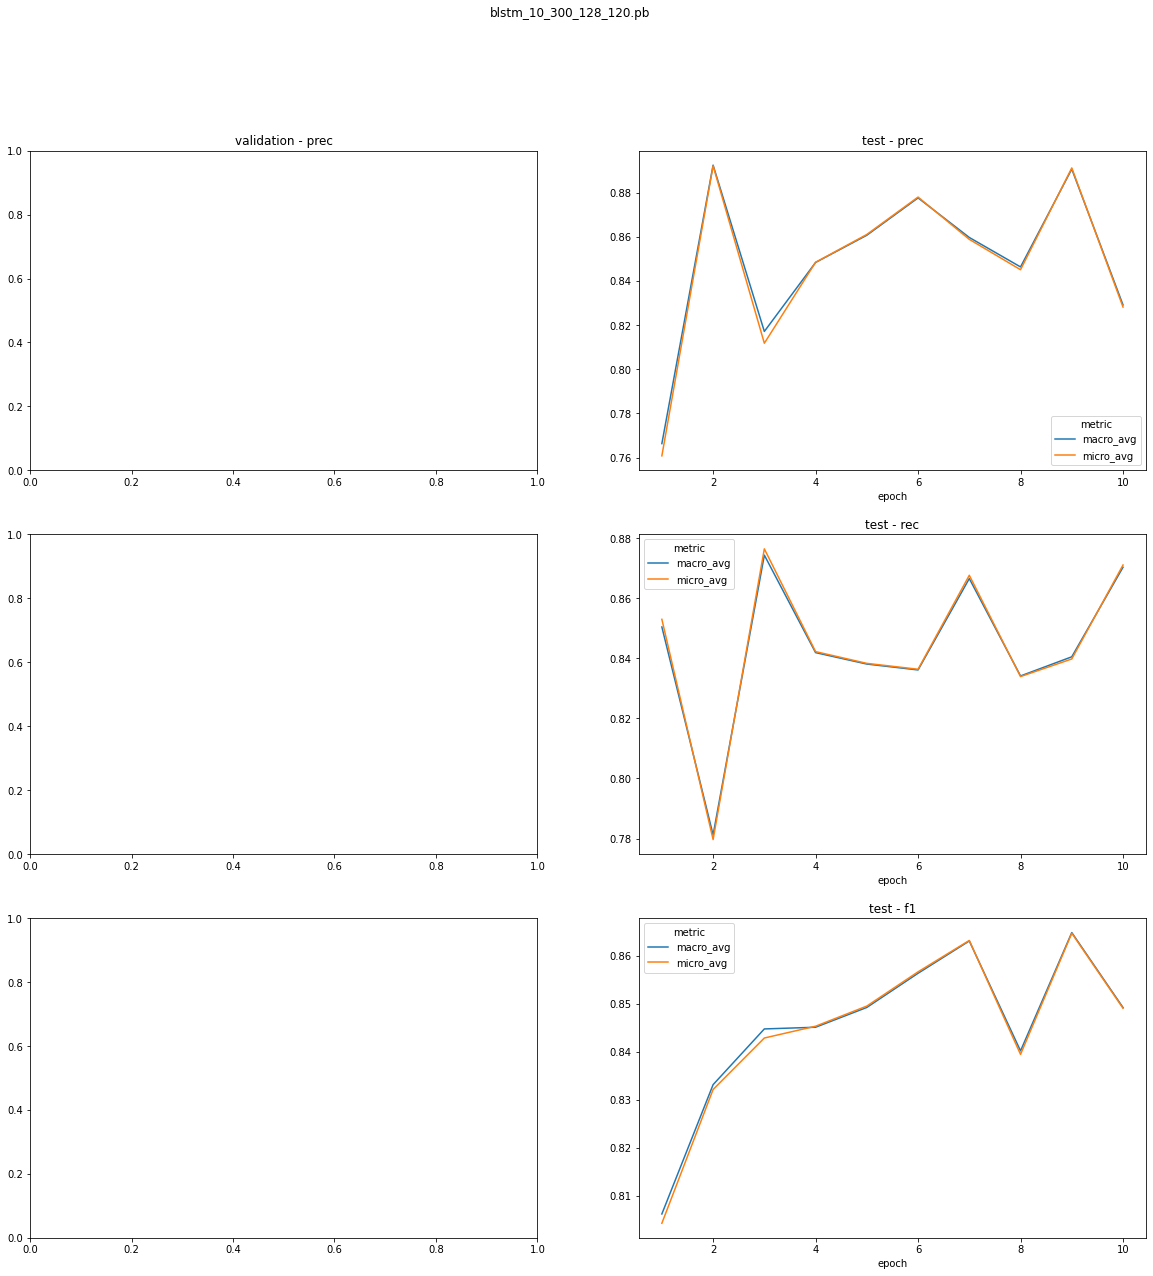

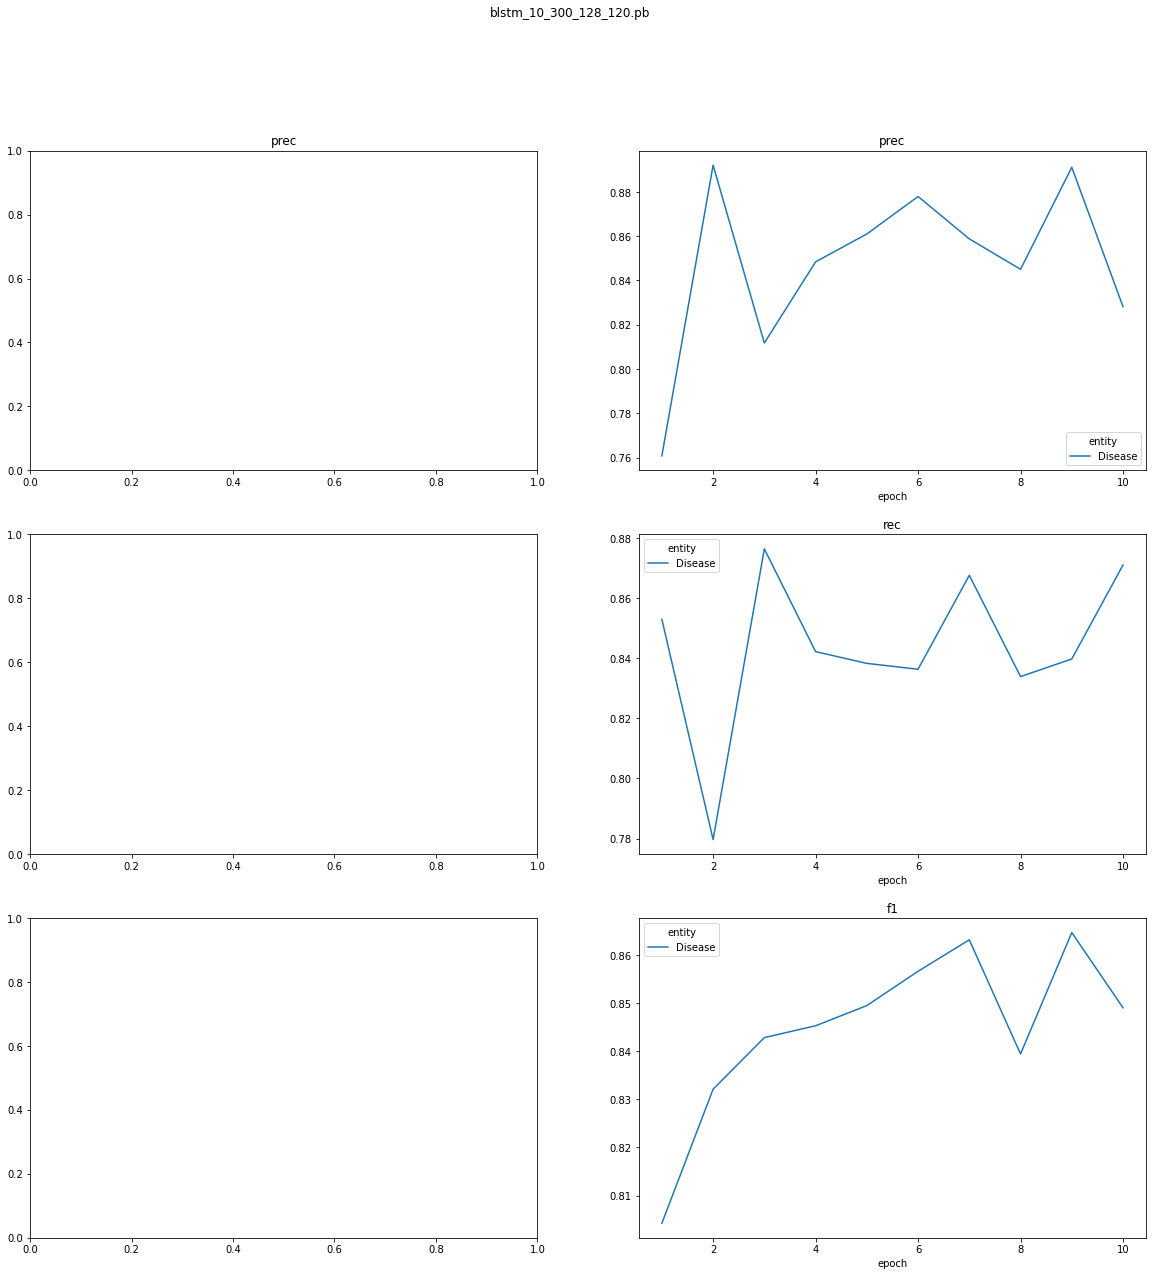

In [ ]:
ner_log_parser.loss_plot('/content/ner_logs/NerDLApproach_af2879065348.log')

### Saving the trained model

In [ ]:
ner_model.stages

In [ ]:
ner_model.stages[1].write().overwrite().save('NER_glove_e10_b8')

In [ ]:
!ls -lt

## Prediction Pipeline

In [ ]:
document = DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")

sentence = SentenceDetector()\
        .setInputCols(['document'])\
        .setOutputCol('sentence')

token = Tokenizer()\
        .setInputCols(['sentence'])\
        .setOutputCol('token')

glove_embeddings = WordEmbeddingsModel.pretrained('glove_6B_300','xx')\
        .setInputCols(["sentence", "token"])\
        .setOutputCol("embeddings")
  
loaded_ner_model = NerDLModel.load("NER_glove_e10_b8")\
        .setInputCols(["sentence", "token", "embeddings"])\
        .setOutputCol("ner")

converter = NerConverter()\
        .setInputCols(["sentence", "token", "ner"])\
        .setOutputCol("ner_span")

ner_prediction_pipeline = Pipeline(stages = [
        document,
        sentence,
        token,
        glove_embeddings,
        loaded_ner_model,
        converter
])

In [ ]:
empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)


In [ ]:
text = '''
A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting .
'''

sample_data = spark.createDataFrame([[text]]).toDF("text")

sample_data.show(truncate=100)

In [ ]:
preds = prediction_model.transform(sample_data)

preds.select(F.explode(F.arrays_zip("ner_span.result","ner_span.metadata")).alias("entities")) \
.select(F.expr("entities['0']").alias("chunk"),
        F.expr("entities['1'].entity").alias("entity")).show(truncate=False)

In [ ]:
from sparknlp.base import LightPipeline

light_model = LightPipeline(prediction_model)

In [ ]:
result = light_model.annotate(text)

list(zip(result['token'], result['ner']))

In [ ]:
import pandas as pd

result = light_model.fullAnnotate(text)

ner_df= pd.DataFrame([(int(x.metadata['sentence']), x.result, x.begin, x.end, y.result) for x,y in zip(result[0]["token"], result[0]["ner"])], 
                      columns=['sent_id','token','start','end','ner'])
ner_df.head(20)

### Highlight Entities

In [ ]:
ann_text = light_model.fullAnnotate(text)[0]
ann_text.keys()

In [ ]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()
print ('Standard Output')
visualiser.display(ann_text, label_col='ner_span', document_col='document')
